In [1]:
from collections import defaultdict
import math
import os 
import numpy as np 

In [22]:
class MaxEnt(object):
    def __init__(self):
        self.feats = defaultdict(int)
        self.trainset = []  #训练集
        self.labels = set() #标签集

    def load_data(self):
        # 拿到路径
        path = '/workspace/mnt/group/customization/pengyuyan/dataMining/TanCorp-12-Txt_SegRes_2_1_53907f/train_SegRes/'
        # 拿到类别
        classes = os.listdir(path)
        classes = [ cls.split('_')[0] for cls in classes]
        classes.pop(classes.index(".DS"))
        for cls in classes:
            
            # 拿到了cls的名字，后面用于创建变量使用
            s = os.path.join( path,  cls + '_SegRes')
            filelist = os.listdir( s )
            for file in filelist:
                # 拿到了每一篇文章

                # 拿到了每一个文件:
#                 if file.endswith(".txt"):
                filepath  = os.path.join( s , file )

                ss = ''
                with open(filepath, "rb") as f:
                    ss += f.readline().decode('gbk')

                word  = ss.split('<<::=::>>')[0].split(',')[:-1]
                count = ss.split('<<::=::>>')[1].split(',')[:-1]

                self.labels.add(cls)
                for f in set(word):
                    self.feats[(cls,f)] += 1    #(label,f)元组为特征
                self.trainset.append([cls] + word)

    def __initparams(self):
        self.size = len(self.trainset)
        self.M = max([len(record)-1 for record in self.trainset])   #GIS训练算法的M参数

        self.ep_ = [0.0] * len(self.feats)
        for i,f in enumerate(self.feats):
            self.ep_[i] = float(self.feats[f])/float(self.size)     #计算经验分布的特征期望
            self.feats[f] = i   #为每个特征函数分配id

        self.w = [0.0]*len(self.feats)  #初始化权重
        self.lastw = self.w

    def probwgt(self, features, label):     #计算每个特征权重的指数
        wgt = 0.0
        for f in features:
            if (label,f) in self.feats:
                wgt += self.w[self.feats[(label,f)]]
        return math.exp(wgt)

    """calculate feature expectation on model distribution
    """
    def calprob(self, features):    #计算条件概率
        wgts = [(self.probwgt(features,l),l) for l in self.labels]
        Z = sum([w for w,l in wgts])    #归一化参数
        prob = [(w/Z,l) for w,l in wgts]    #概率向量
        return prob

    def Ep(self):   #特征函数
        ep = [0.0] * len(self.feats)
        for record in self.trainset:    #从训练集中迭代输出特征
            features = record[1:]
            prob = self.calprob(features)   #计算条件概率p(y|x)
            for f in features:
                for w,l in prob:
                    if (l,f) in self.feats: #来自训练数据的特征
                        idx = self.feats[(l,f)] #获取特征id
                        ep[idx] += w * (1.0/self.size)   # sum(1/N * f(y,x) * p(y|x)), p(x)=1/N
        return ep

    def __convergence(self,lastw,w):    #收敛条件
        for w1,w2 in zip(lastw,w):
            if abs(w1-w2) >= 0.01: return False
        return True

    def train(self,maxiter=1000):   #训练主函数，默认迭代次数1000
        reslist = []
        self.__initparams() #初始化参数
        for i in range(maxiter):
            print("iter %d ..." % (i+1))
            self.ep = self.Ep()     #计算模型分布的特征期望
            self.lastw = self.w[:]
            for i,win in enumerate(self.w):
                delta = 1.0/self.M * math.log(self.ep_[i]/self.ep[i])
                self.w[i] += delta  #更新w
            #print self.w, self.feats

            error , correct = self.test()
            reslist.append((i,error,correct))
            print('error is {} , correct is {}'.format(error,correct))
        return reslist
            
            # if self.__convergence(self.lastw,self.w):    #判断算法是否收敛
            #     break

    def test(self):
        # 拿到路径
        path = "/workspace/mnt/group/customization/pengyuyan/dataMining/TanCorp-12-Txt_SegRes_2_1_53907f/test_SegRes/"
        # 拿到类别
        classes = os.listdir(path)
        classes = [ cls.split('_')[0] for cls in classes]

        error = 0
        correct = 0
        for cls in classes:
            
            # 拿到了cls的名字，后面用于创建变量使用
            s = os.path.join( path,  cls + '_SegRes')
            filelist = os.listdir( s )
            for file in filelist:
                # 拿到了每一篇文章

                # 拿到了每一个文件:
                filepath  = os.path.join( s , file )

                ss = ''
                with open(filepath, "rb") as f:
                    ss += f.readline().decode("gbk")
                
                word  = ss.split('<<::=::>>')[0].split(',')[:-1]
                result = self.predict(' '.join( word))[0][1]
                if result == cls:
                    correct +=1
                else:
                    error += 1
        return error ,correct  


    def predict(self,input):
        features = input.strip().split()
        prob = self.calprob(features)
        prob.sort(reverse=True)
        return prob

In [ ]:
model = MaxEnt()
model.load_data()
reslist = model.train()

iter 1 ...
error is 1399 , correct is 3320
iter 2 ...
error is 1306 , correct is 3413
iter 3 ...
error is 1221 , correct is 3498
iter 4 ...
error is 1139 , correct is 3580
iter 5 ...
error is 1054 , correct is 3665
iter 6 ...
error is 984 , correct is 3735
iter 7 ...
error is 918 , correct is 3801
iter 8 ...
error is 864 , correct is 3855
iter 9 ...
error is 813 , correct is 3906
iter 10 ...
error is 783 , correct is 3936
iter 11 ...
error is 753 , correct is 3966
iter 12 ...
error is 725 , correct is 3994
iter 13 ...
error is 697 , correct is 4022
iter 14 ...
error is 673 , correct is 4046
iter 15 ...
error is 656 , correct is 4063
iter 16 ...
error is 644 , correct is 4075
iter 17 ...
error is 624 , correct is 4095
iter 18 ...
error is 608 , correct is 4111
iter 19 ...
error is 599 , correct is 4120
iter 20 ...
error is 593 , correct is 4126
iter 21 ...
error is 586 , correct is 4133
iter 22 ...
error is 574 , correct is 4145
iter 23 ...
error is 566 , correct is 4153
iter 24 ...
err

In [24]:
reslist

[(175538, 1399, 3320),
 (175538, 1306, 3413),
 (175538, 1221, 3498),
 (175538, 1139, 3580),
 (175538, 1054, 3665),
 (175538, 984, 3735),
 (175538, 918, 3801),
 (175538, 864, 3855),
 (175538, 813, 3906),
 (175538, 783, 3936),
 (175538, 753, 3966),
 (175538, 725, 3994),
 (175538, 697, 4022),
 (175538, 673, 4046),
 (175538, 656, 4063),
 (175538, 644, 4075),
 (175538, 624, 4095),
 (175538, 608, 4111),
 (175538, 599, 4120),
 (175538, 593, 4126),
 (175538, 586, 4133),
 (175538, 574, 4145),
 (175538, 566, 4153),
 (175538, 556, 4163),
 (175538, 544, 4175),
 (175538, 531, 4188),
 (175538, 520, 4199),
 (175538, 513, 4206),
 (175538, 504, 4215),
 (175538, 494, 4225),
 (175538, 490, 4229),
 (175538, 486, 4233),
 (175538, 479, 4240),
 (175538, 475, 4244),
 (175538, 470, 4249),
 (175538, 469, 4250),
 (175538, 466, 4253),
 (175538, 466, 4253),
 (175538, 460, 4259),
 (175538, 459, 4260),
 (175538, 455, 4264),
 (175538, 452, 4267),
 (175538, 442, 4277),
 (175538, 441, 4278),
 (175538, 439, 4280),
 (175

In [35]:
print("The Accuracy is {}".format(1 - min([t[1]/(t[1] + t[2])for t in reslist])))

The Accuracy is 0.9374867556685739


In [40]:
with open("./train.log", "w") as f:
    for res in reslist:
        f.write(str(res[0]))
        f.write('    ')
        f.write(str(res[1]))
        f.write('    ')
        f.write(str(res[2]))
        f.write("\n")

In [41]:
import pandas as pd

In [49]:
df = pd.DataFrame(reslist, columns=['Nomeaning', "error", "correct"])

In [59]:
import matplotlib.pyplot as plt

font1 = {'family' : 'Times New Roman',  
'weight' : 'normal',  
'size'   : 9,  
} 

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


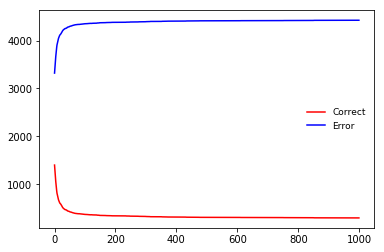

In [61]:
plt.plot(df["error"], color='red', label='Correct')
plt.legend(loc='right', prop=font1, frameon=False)
plt.plot(df["correct"], color='blue', label='Error')
plt.legend(loc='right', prop=font1, frameon=False)

,Nomeaning,error,correct
0,175538,1399,3320
1,175538,1306,3413
2,175538,1221,3498
3,175538,1139,3580
4,175538,1054,3665
